In [63]:
import sys
from pathlib import Path

# Add the project root to sys.path
project_root = Path().resolve().parent  # Adjust as needed to point to the root folder
sys.path.append(str(project_root))

print(sys.path)  # Check if the path is added


['C:\\Program Files\\Python310\\python310.zip', 'C:\\Program Files\\Python310\\DLLs', 'C:\\Program Files\\Python310\\lib', 'C:\\Program Files\\Python310', 'g:\\Work\\DS\\neural-net-from-scratch\\.venv', '', 'g:\\Work\\DS\\neural-net-from-scratch\\.venv\\lib\\site-packages', 'g:\\Work\\DS\\neural-net-from-scratch\\.venv\\lib\\site-packages\\win32', 'g:\\Work\\DS\\neural-net-from-scratch\\.venv\\lib\\site-packages\\win32\\lib', 'g:\\Work\\DS\\neural-net-from-scratch\\.venv\\lib\\site-packages\\Pythonwin', 'G:\\Work\\DS\\neural-net-from-scratch', 'G:\\Work\\DS\\neural-net-from-scratch']


In [64]:
#
# Verify Reading Dataset via MnistDataloader class
#
%matplotlib inline
import random
import matplotlib.pyplot as plt
from os.path  import join
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split

#
# Set file paths based on added MNIST Datasets
#
input_path = '../data'
data = np.array(pd.read_csv(join(input_path, 'train.csv')))
print(data.shape)

train_set, dev_set = train_test_split(data, test_size=0.2, random_state=42)
X_train = train_set[:1000, 1:data.shape[1]]
y_train = train_set[:1000, 0:1]
X_dev = dev_set[:100, 1:data.shape[1]]
y_dev = dev_set[:100, 0:1]

#
# Helper function to show a list of images with their relating titles
#
def show_images(images, title_texts):
    cols = 5
    rows = int(len(images)/cols) + 1
    plt.figure(figsize=(30,20))
    index = 1    
    for x in zip(images, title_texts):        
        image = x[0]        
        title_text = x[1]
        plt.subplot(rows, cols, index)        
        plt.imshow(image, cmap=plt.cm.gray)
        if (title_text != ''):
            plt.title(title_text, fontsize = 15);        
        index += 1



(42000, 785)


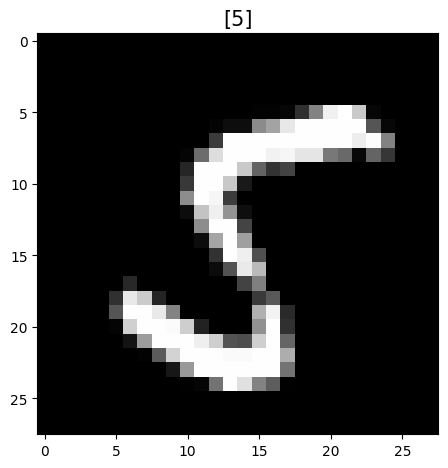

In [65]:
show_images([X_train[1].reshape(28, 28)], [y_train[1]])

In [66]:
from sklearn.preprocessing import OneHotEncoder

digit_encoder = OneHotEncoder()
Y_true = digit_encoder.fit_transform(y_train).toarray().T
Y_true.shape

(10, 1000)

### Neural Network

In [67]:
def sigmoid(x):
    return np.exp(x)/(1 + np.exp(x))

def init_params():
    W1 = np.random.randn(28, 784)
    b1 = np.random.rand(28, 1)
    W2 = np.random.randn(28, 28)
    b2 = np.random.rand(28, 1)
    Wy = np.random.randn(10, 28)
    by = np.random.rand(10, 1)
    return W1, b1, W2, b2, Wy, by

def forward_prop(A0, W1,b1,W2,b2,Wy,by):
    A1 = W1.dot(A0) + b1
    Z2 = W2.dot(A1) + b2
    A2 = sigmoid(Z2)
    Zy = Wy.dot(A2) + by
    Y = sigmoid(Zy)
    return Y, A2, A1

def cost(Y, Y_true, m):
    return np.sum(np.square(Y_true - Y)) / (2 * m)

def back_prop(Y, Y_true, Wy, A2, W2, A1, A0, m):
    dC_dZy = - ((Y - Y_true) * Y * (1-Y))/m
    dZy_dWy = A2.T # Transpose for matching dimension
    #Ouput Layer
    dC_dWy = np.dot(dC_dZy, dZy_dWy)
    dC_dby = np.sum(dC_dZy, axis=1, keepdims=True)

    dC_dZ2 = np.dot(Wy.T, dC_dZy) * A2 * (1 - A2) 
    #2nd Hidden Layer
    dC_dW2 = np.dot(dC_dZ2, A1.T)
    dC_db2 = np.sum(dC_dZ2, axis=1, keepdims=True)

    dC_dZ1 = np.dot(W2.T, dC_dZ2) * A1 * (1 - A1)  
    #1st Hidden Layer
    dC_dW1 = np.dot(dC_dZ1, A0.T)
    dC_db1 = np.sum(dC_dZ1, axis=1, keepdims=True)   

    return dC_dW1, dC_db1, dC_dW2, dC_db2, dC_dWy, dC_dby

def gradient_descent(alpha, W1, b1, W2, b2, Wy, by, dC_dW1, dC_db1, dC_dW2, dC_db2, dC_dWy, dC_dby):
    W1 = W1 - alpha * dC_dW1
    b1 = b1 - alpha * dC_db1
    W2 = W2 - alpha * dC_dW2
    b2 = b2 - alpha * dC_db2
    Wy = Wy - alpha * dC_dWy
    by = by - alpha * dC_dby
    return W1, b1, W2, b2, Wy, by

def predict(test_data, W1, b1, W2, b2, Wy, by):
        #expects scaled values
        A1 = W1.dot(test_data) + b1
        Z2 = W2.dot(A1) + b2
        A2 = sigmoid(Z2)
        Zy = Wy.dot(A2) + by
        Y_pred = sigmoid(Zy)
        return Y_pred


In [74]:
from sklearn.preprocessing import MinMaxScaler, StandardScaler

scaler = MinMaxScaler()
A0 = scaler.fit_transform(X_train)
A0 = A0.reshape(784 , A0.shape[0])
A0.shape

(784, 1000)

In [75]:
n = Y_true.shape[0]
m = Y_true.shape[1]
W1,b1,W2,b2,Wy,by = init_params()
alpha = 0.001 #learning rate

for iteration in range(500):
    Y, A2, A1 = forward_prop(A0, W1, b1, W2, b2, Wy, by)

    dC_dW1, dC_db1, dC_dW2, dC_db2, dC_dWy, dC_dby = back_prop(Y, Y_true, Wy, A2, W2, A1, A0, m)

    W1, b1, W2, b2, Wy, by = gradient_descent(alpha, W1, b1, W2, b2, Wy, by, dC_dW1, dC_db1, dC_dW2, dC_db2, dC_dWy, dC_dby)

    if iteration % 10 == 0:
         
        print(f"Cost for {iteration} iteration: {cost(Y, Y_true, m)}")


Cost for 0 iteration: 1.8632512301069206
Cost for 10 iteration: 1.8531931088181535
Cost for 20 iteration: 1.8430905859781952
Cost for 30 iteration: 1.8349099403299483
Cost for 40 iteration: 1.8270261516159212
Cost for 50 iteration: 1.81776891280278
Cost for 60 iteration: 1.8095692256002476
Cost for 70 iteration: 1.8024817284945402
Cost for 80 iteration: 1.794821438429825
Cost for 90 iteration: 1.7869311923854996
Cost for 100 iteration: 1.7780898597931412
Cost for 110 iteration: 1.7690912800120124
Cost for 120 iteration: 1.7595509505208338
Cost for 130 iteration: 1.7510366258258816
Cost for 140 iteration: 1.7438055385247986
Cost for 150 iteration: 1.7369648238726414
Cost for 160 iteration: 1.7286219678709958
Cost for 170 iteration: 1.7210528453515028
Cost for 180 iteration: 1.7146909483953794
Cost for 190 iteration: 1.7089350025573757
Cost for 200 iteration: 1.7033297555332343
Cost for 210 iteration: 1.6976538021669274
Cost for 220 iteration: 1.6927304948199058
Cost for 230 iteration: 1

C:\Users\Harshavardhan Patil\AppData\Local\Temp\ipykernel_3684\51299927.py:2: RuntimeWarning: overflow encountered in exp
  return np.exp(x)/(1 + np.exp(x))
C:\Users\Harshavardhan Patil\AppData\Local\Temp\ipykernel_3684\51299927.py:2: RuntimeWarning: invalid value encountered in divide
  return np.exp(x)/(1 + np.exp(x))


0.06


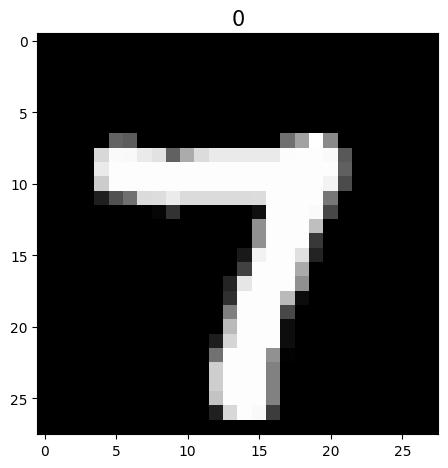

In [76]:
from sklearn.metrics import accuracy_score

def one_hot_to_digit(predictions):
    # Use argmax to find the index of the maximum value in each column (sample)
    digit_labels = np.argmax(predictions, axis=0)
    return digit_labels

test_data = scaler.transform(X_dev)
test_data = test_data.reshape(784 , test_data.shape[0])
Y_pred = predict(test_data, W1, b1, W2, b2, Wy, by)
preds = one_hot_to_digit(Y_pred)

print(accuracy_score(y_dev, preds))
show_images([X_dev[8].reshape(28, 28)], [preds[8]])
